In [1]:
import os
import cv2
import gc
import numpy as np
import splitfolders
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.applications import ResNet50,ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
%matplotlib inline

In [2]:
labels = ['Normal', 'Potholes']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
data = get_data('TestFolder')

/var/folders/7c/s_44qy7x2xl31y_8nm69xyg80000gn/T/ipykernel_69110/3542315726.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


### Add selective search to draw boxes

### Add code to get our annotated data 

### Add code to find intersection over union

In [4]:
splitfolders.ratio("TestFolder", output="output",
    seed=1337, ratio=(.6, .4), group_prefix=None, move=False) # default values

Copying files: 30 files [00:00, 377.53 files/s]


In [5]:
train = get_data('output/train')
val = get_data('output/val')

'NoneType' object is not subscriptable


/var/folders/7c/s_44qy7x2xl31y_8nm69xyg80000gn/T/ipykernel_69110/3542315726.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


'NoneType' object is not subscriptable


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

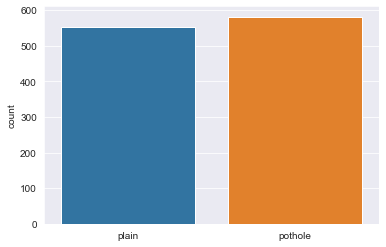

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("plain")
    else:
        l.append("pothole")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'Normal')

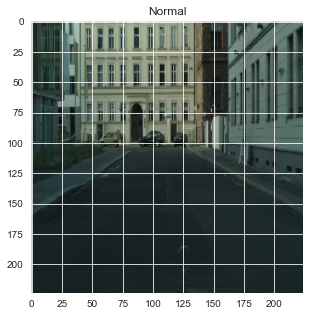

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'Potholes')

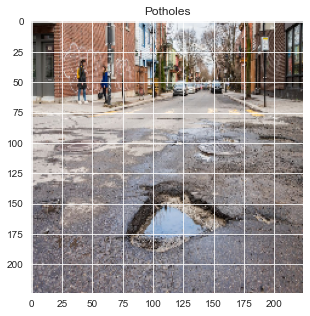

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [9]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### OR USE TRAINED MODEL

In [11]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

2023-02-18 14:36:38.604739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [12]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [14]:
model_file = 'model/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'

#maximizing val_accuracy, store only the best models  
checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

#If after 3 epochs the val_accuracy does not improve just stop 
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

In [15]:
history = model.fit(x_train,y_train,epochs = 10,batch_size = 32, validation_data = (x_val, y_val), verbose = 2,shuffle = True,callbacks = [checkpoint,early])

Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.51176, saving model to model/weights.01-0.51.hdf5
36/36 - 29s - loss: 0.6690 - accuracy: 0.5388 - val_loss: 0.6509 - val_accuracy: 0.5118 - 29s/epoch - 796ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.51176
36/36 - 27s - loss: 0.6417 - accuracy: 0.5212 - val_loss: 0.6338 - val_accuracy: 0.5118 - 27s/epoch - 745ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.51176 to 0.52647, saving model to model/weights.03-0.53.hdf5
36/36 - 26s - loss: 0.6266 - accuracy: 0.5353 - val_loss: 0.6164 - val_accuracy: 0.5265 - 26s/epoch - 723ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.52647 to 0.57794, saving model to model/weights.04-0.58.hdf5
36/36 - 25s - loss: 0.6077 - accuracy: 0.5644 - val_loss: 0.5976 - val_accuracy: 0.5779 - 25s/epoch - 706ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.57794 to 0.63676, saving model to model/weights.05-0.64.hdf5
36/36 - 29s - loss: 0.5887 - accuracy: 0.6314 - val_los

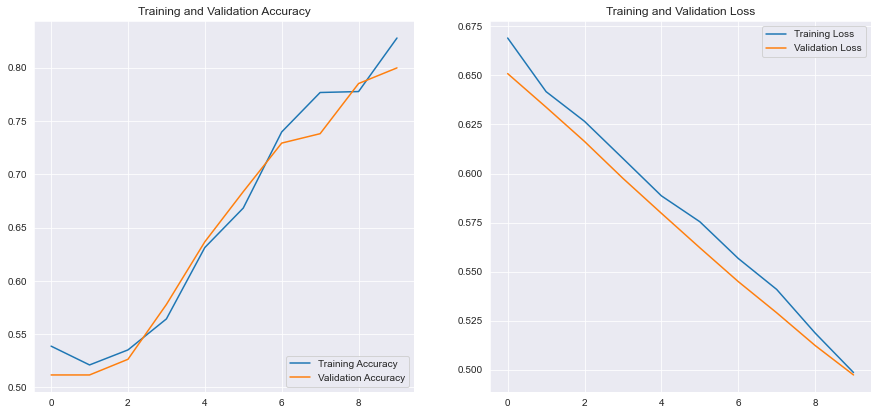

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
from tensorflow.keras.models import load_model

In [19]:
y_pred=model.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)

22/22 [==============================] - 3s 140ms/step


In [20]:
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.62      0.95      0.75       218
           1       0.97      0.73      0.83       462

    accuracy                           0.80       680
   macro avg       0.80      0.84      0.79       680
weighted avg       0.86      0.80      0.81       680



In [21]:
print(confusion_matrix(y_pred,y_val))

[[207  11]
 [125 337]]


In [22]:
from sklearn.metrics import roc_curve

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [24]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)

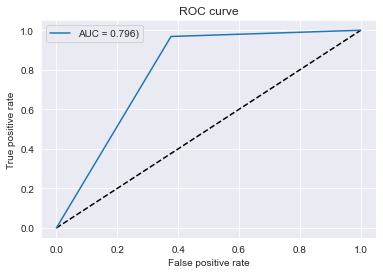

In [25]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [26]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

17.jpg
1/1 [==============================] - 0s 21ms/step
16.jpg
1/1 [==============================] - 0s 21ms/step
18.jpg
1/1 [==============================] - 0s 25ms/step


/var/folders/7c/s_44qy7x2xl31y_8nm69xyg80000gn/T/ipykernel_69110/2050279298.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


1/1 [==============================] - 0s 21ms/step


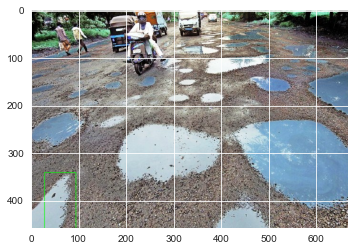

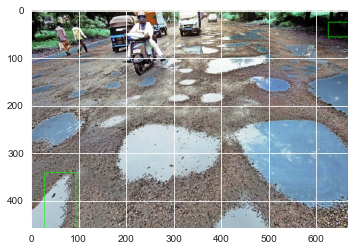

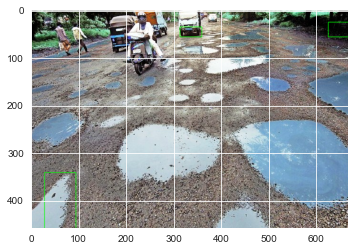

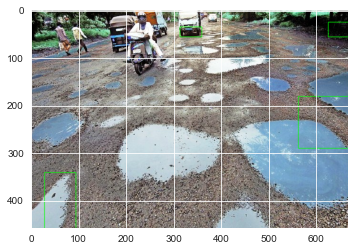

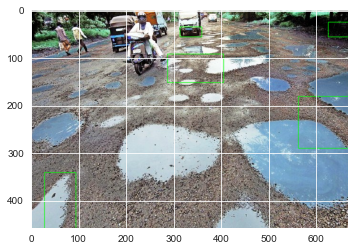

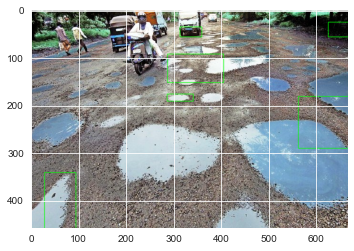

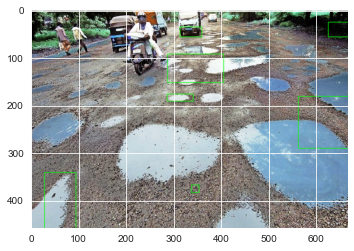

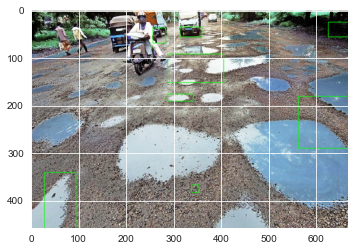

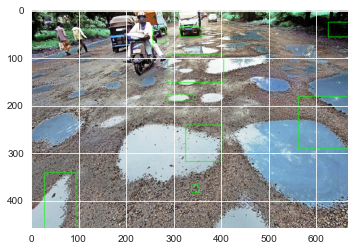

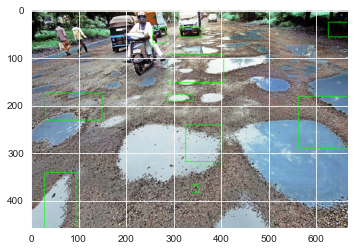

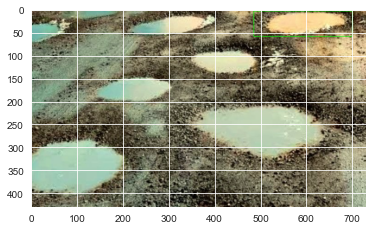

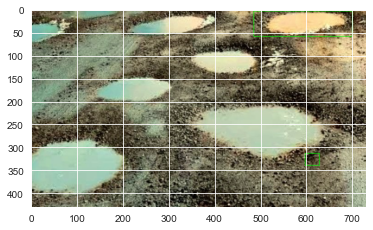

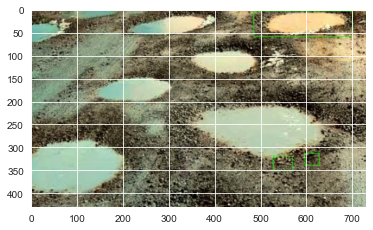

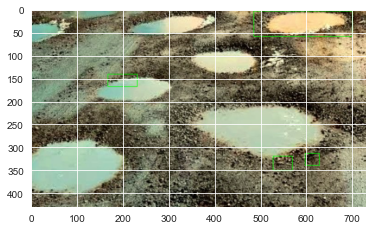

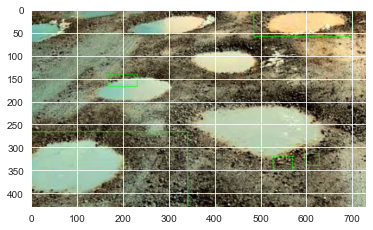

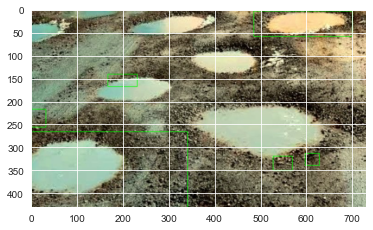

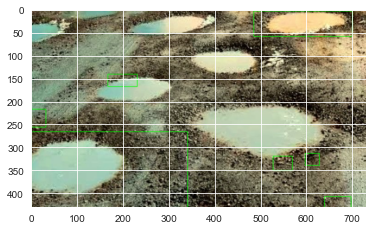

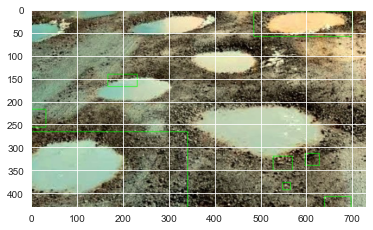

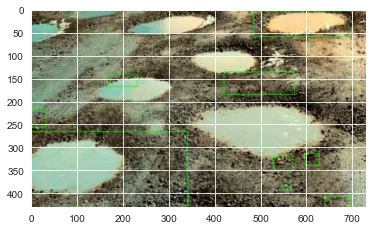

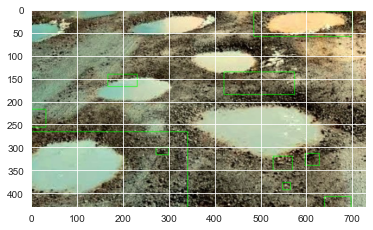

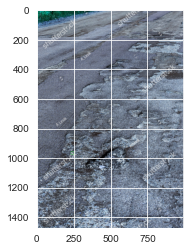

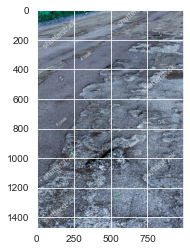

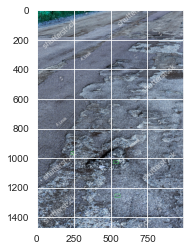

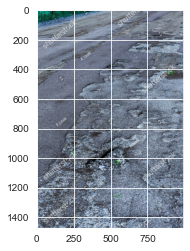

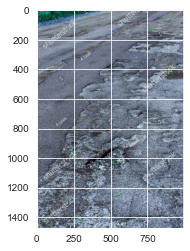

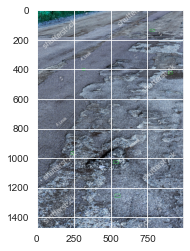

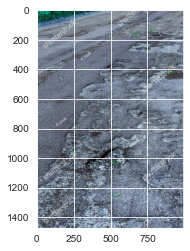

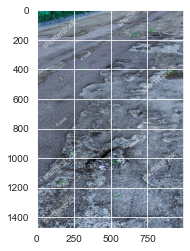

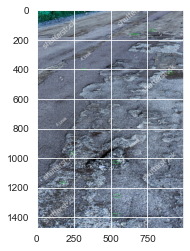

In [33]:
z=0
count = 0
for e,i in enumerate(os.listdir('AData_S/test')):
    z += 1
    print(i)
    img = cv2.imread(os.path.join('AData_S/test',i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    #print(ssresults)
    imout = img.copy()
    for e,result in enumerate(ssresults):
        if e < 10:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img)
            if out[0][1] > 0.70:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                #count += 1
                #print("Number of potholes :",count)
                plt.figure()
                plt.imshow(imout)